In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [21]:
data_train = pd.read_json('../../Dataset/Random Acts Of Pizza/train.json')
y = data_train.pop('requester_received_pizza')

In [22]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 0 to 4039
Data columns (total 31 columns):
giver_username_if_known                                 4040 non-null object
number_of_downvotes_of_request_at_retrieval             4040 non-null int64
number_of_upvotes_of_request_at_retrieval               4040 non-null int64
post_was_edited                                         4040 non-null int64
request_id                                              4040 non-null object
request_number_of_comments_at_retrieval                 4040 non-null int64
request_text                                            4040 non-null object
request_text_edit_aware                                 4040 non-null object
request_title                                           4040 non-null object
requester_account_age_in_days_at_request                4040 non-null float64
requester_account_age_in_days_at_retrieval              4040 non-null float64
requester_days_since_first_post_on_raop_at_reque

In [23]:
def applyNMF(data_samples):
    print("Extracting tf-idf features for NMF...")
    tfidf_vectorizer = TfidfVectorizer(max_df=1.0,min_df=1,stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(data_samples)
    print("Fitting the NMF model with tf-idf features,"
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
    nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)
    return nmf.transform(tfidf)

In [24]:
## Applying Non Negative Matrix Factorisation on Request Posts

topics = applyNMF(data_train['request_text_edit_aware'])
print(topics.shape)

Extracting tf-idf features for NMF...
Fitting the NMF model with tf-idf features,n_samples=2000 and n_features=1000...
(4040, 20)


In [25]:
for i in range(topics.shape[1]):
    data_train['request_text_topic_{}'.format(i)] = topics[:,i]

In [26]:
data_train.giver_username_if_known = data_train.giver_username_if_known.map({'N/A':0})
data_train.giver_username_if_known.fillna(1,inplace=True)

In [27]:
## Adding the length of the request as the feature

data_train['request_length'] = [len(x) for x in data_train['request_text_edit_aware']]

In [28]:
data_train.requester_user_flair.unique()

array([None, u'shroom', u'PIF'], dtype=object)

In [29]:
data_train['flair'] = data_train['requester_user_flair'].map({None:0,'shroom':1,'PIF':2})

In [30]:
data_train.drop(labels=[i for i in data_train.columns if data_train[i].dtype == 'object'],axis=1,inplace=True)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 0 to 4039
Data columns (total 46 columns):
giver_username_if_known                                 4040 non-null float64
number_of_downvotes_of_request_at_retrieval             4040 non-null int64
number_of_upvotes_of_request_at_retrieval               4040 non-null int64
post_was_edited                                         4040 non-null int64
request_number_of_comments_at_retrieval                 4040 non-null int64
requester_account_age_in_days_at_request                4040 non-null float64
requester_account_age_in_days_at_retrieval              4040 non-null float64
requester_days_since_first_post_on_raop_at_request      4040 non-null float64
requester_days_since_first_post_on_raop_at_retrieval    4040 non-null float64
requester_number_of_comments_at_request                 4040 non-null int64
requester_number_of_comments_at_retrieval               4040 non-null int64
requester_number_of_comments_in_raop_at_request

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,accuracy_score

In [32]:
rfc = RandomForestClassifier(n_estimators=100)

In [33]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data_train,y,test_size=0.3,random_state=7)

In [34]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
test_rfc = rfc.predict(X_test)

In [36]:
roc_auc_score(y_test,test_rfc)

1.0

In [37]:
from sklearn.cross_validation import cross_val_score

In [38]:
def scorer(estimator,X,y):
    return roc_auc_score(y,estimator.predict(X))

In [39]:
def apply_model(model,df,y,cv=5):
    score = cross_val_score(model,df.values,y,scoring=scorer,cv=5)
    return score

In [40]:
apply_model(rfc,data_train,y,cv=5)

array([ 1.,  1.,  1.,  1.,  1.])

In [44]:
pd.concat([data_train,y],axis=1).to_csv('train.csv')

In [67]:
try:
    data_train.pop('flair')
except:
    pass
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 0 to 4039
Data columns (total 45 columns):
giver_username_if_known                                 4040 non-null float64
number_of_downvotes_of_request_at_retrieval             4040 non-null int64
number_of_upvotes_of_request_at_retrieval               4040 non-null int64
post_was_edited                                         4040 non-null int64
request_number_of_comments_at_retrieval                 4040 non-null int64
requester_account_age_in_days_at_request                4040 non-null float64
requester_account_age_in_days_at_retrieval              4040 non-null float64
requester_days_since_first_post_on_raop_at_request      4040 non-null float64
requester_days_since_first_post_on_raop_at_retrieval    4040 non-null float64
requester_number_of_comments_at_request                 4040 non-null int64
requester_number_of_comments_at_retrieval               4040 non-null int64
requester_number_of_comments_in_raop_at_request

In [57]:
from sklearn.learning_curve import learning_curve

In [75]:
from sklearn.linear_model import Lasso
linear = Lasso(max_iter=2000)
train_sizes,train_scores,test_scores = learning_curve(linear,data_train.values,y,cv=5)

In [76]:
y_train = np.mean(train_scores,axis=1)
y_test = np.mean(test_scores,axis=1)
y_train_mean = np.mean(train_scores,axis=1)
y_train_std = np.std(train_scores,axis=1)
y_test_mean = np.mean(test_scores,axis=1)
y_test_std = np.std(test_scores,axis=1)

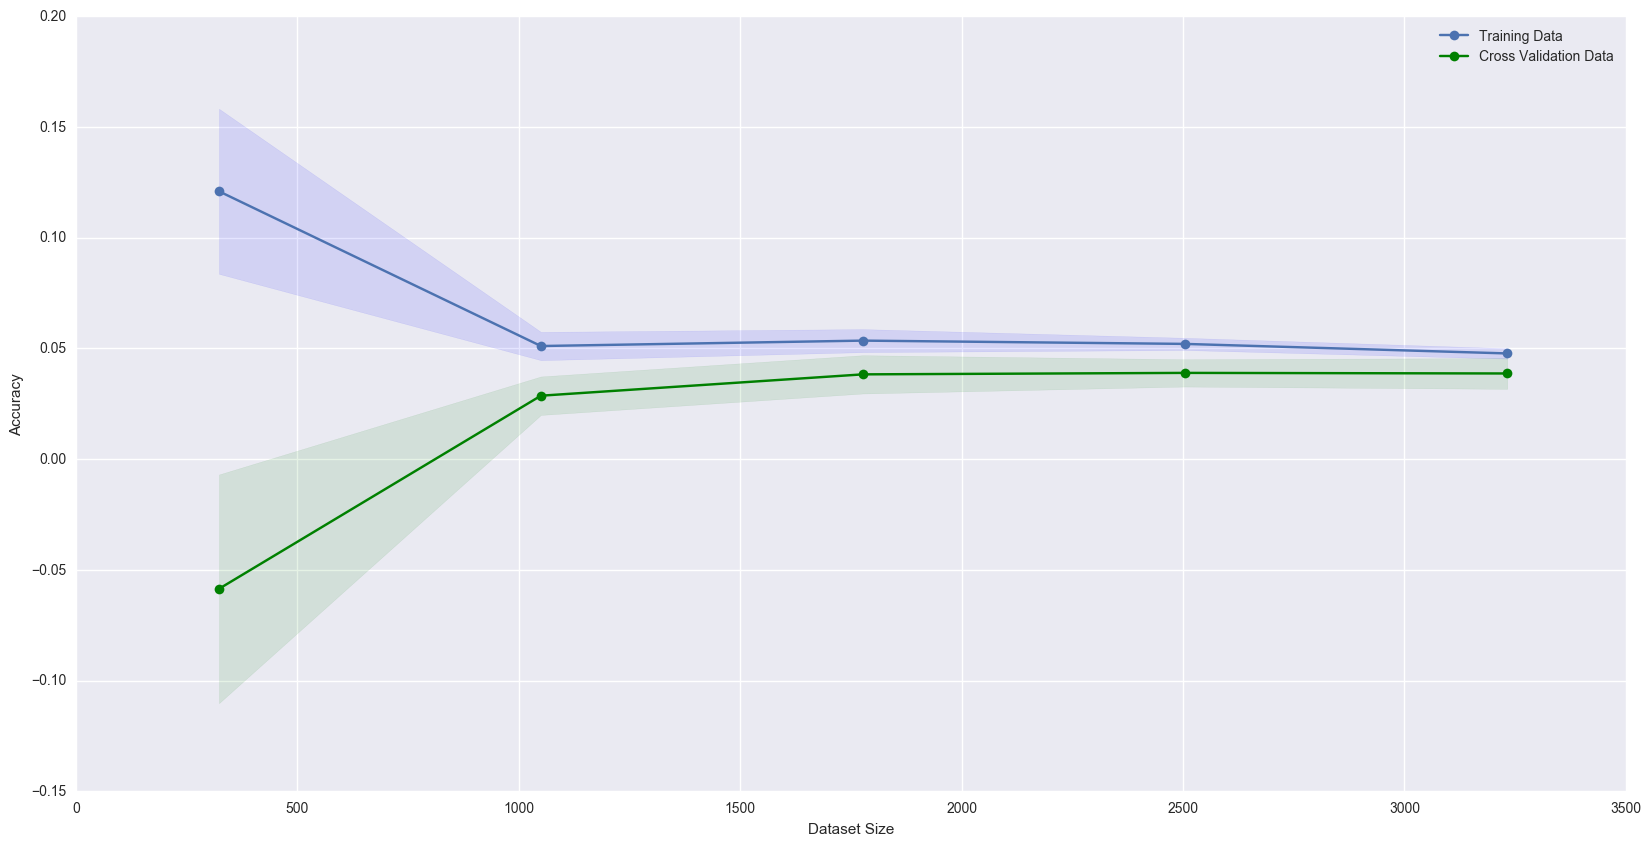

In [77]:
plt.fill_between(train_sizes,y_train_mean-y_train_std,y_train_mean+y_train_std,color='b',alpha=0.1)
plt.fill_between(train_sizes,y_test_mean-y_test_std,y_test_mean+y_test_std,color='g',alpha=0.1)
plt.plot(train_sizes,y_train,'o-',label='Training Data')
plt.plot(train_sizes,y_test,'o-',color='g',label='Cross Validation Data')
plt.xlabel('Dataset Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()